# Example

This notebook demonstrates:
* Training assay models
* Training confidence models and assigning confidence levels
* Measuring confidence level accuracy

In the absence of publicly available timestamped data, we assign arbitrary assay dates to a dataset from SIMPD (https://doi.org/10.1186/s13321-023-00787-9).

In [1]:
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, r2_score
from tqdm import tqdm

from ocla.calibration import (
    Calibration,
    assign_calibration_levels,
    get_baseline_calibration_data,
    get_global_calibration_data,
)
from ocla.confidence import CONFIDENCE_THRESHOLDS, ModelConfidence, assign_confidence_level
from ocla.models import Model, ModelType
from ocla.utilities import Transform, get_training_dates

INFO:rdkit:Enabling RDKit 2024.03.5 jupyter extensions


In [2]:
CONFIDENCE_LEVELS = [item.name for item in list(ModelConfidence)]
LOG_THRESHOLDS = np.log10(CONFIDENCE_THRESHOLDS)
COLORS = [
    (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
    (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
    (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
    (0.8, 0.47058823529411764, 0.7372549019607844),
]
CALIBRATION_LEVELS = [Calibration.UNDERCONFIDENT.name, Calibration.CORRECT.name, Calibration.OVERCONFIDENT.name]
CALIBRATION_COLORS = [
    (0.9254901960784314, 0.8823529411764706, 0.2),
    (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
    (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
]

In [3]:
MODEL_TYPE = ModelType.GAUSSIAN_PROCESS
NUM_SPLITS = 10
# Dopamine D2 receptor dataset.
URL = "https://github.com/rinikerlab/molecular_time_series/raw/403f758faa73ec451ce73391d4ce5ebe292825a8/datasets/source_data/target_CHEMBL217-1.csv.gz"

## Load data and assign arbitrary assay dates

In [4]:
raw_data = pd.read_csv(URL)
print(raw_data.shape)
raw_data.sample(5)

(996, 3)


,canonical_smiles,compound_chembl_id,pchembl_value
600,Cc1ccn(CCCCN2CCN(c3cc(C(F)(F)F)nc(C(C)(C)C)n3)...,CHEMBL382773,7.20
272,CCCN1CCC(c2cn(C)c3ccc(F)cc23)CC1,CHEMBL2207486,7.50
525,Cc1ccc(OCCNCCCOc2ccccc2C)cc1,CHEMBL334545,6.53
130,OC1(c2ccc(Cl)cc2)CCN(CCCCc2ccc(F)cc2)CC1,CHEMBL1940402,7.62
363,CC(C)Oc1ccccc1N1CCN([C@H]2CC[C@@H](NS(=O)(=O)c...,CHEMBL233410,6.89


In [5]:
# Assign arbitrary dates; divide the data into chunks and assign each chunk a different week.
renames = {"canonical_smiles": "smiles", "compound_chembl_id": "mol_id", "pchembl_value": "label"}
data = []
current_date = datetime.date(2023, 1, 1)
for df in np.array_split(raw_data.rename(columns=renames).sort_values("mol_id"), NUM_SPLITS):
    df["assay_date"] = current_date
    current_date += datetime.timedelta(weeks=1)
    data.append(df)
data = pd.concat(data, ignore_index=True)
data["assay_date"] = pd.to_datetime(data["assay_date"])
assert len(data) == len(raw_data)
data.sample(5)

/Users/skearnes/miniconda3/envs/ocla/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,smiles,mol_id,label,assay_date
860,Fc1ccc2c(C3CCN(CCCOc4ccc(CCN5CCOCC5)cc4)CC3)no...,CHEMBL4867978,7.98,2023-02-26
555,CN(C)C[C@H]1C[C@@H]2c3ccccc3Sc3ccc(F)cc3[C@H]2O1,CHEMBL366164,7.92,2023-02-05
393,COc1ccc(S(=O)(=O)N[C@H]2CC[C@H](N3CCN(c4ccccc4...,CHEMBL236621,7.21,2023-01-22
645,O=C1CC(CN2CCC(C(=O)c3ccc(F)cc3)CC2)Cc2[nH]ncc21,CHEMBL397543,6.40,2023-02-12
913,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,CHEMBL54,8.59,2023-03-05


In [6]:
data["assay_date"].value_counts()

assay_date
2023-01-01    100
2023-01-08    100
2023-01-15    100
2023-01-22    100
2023-01-29    100
2023-02-05    100
2023-02-12     99
2023-02-19     99
2023-02-26     99
2023-03-05     99
Name: count, dtype: int64

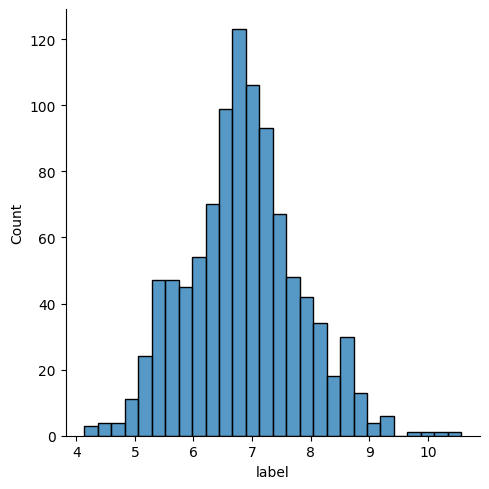

In [7]:
sns.displot(data["label"])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


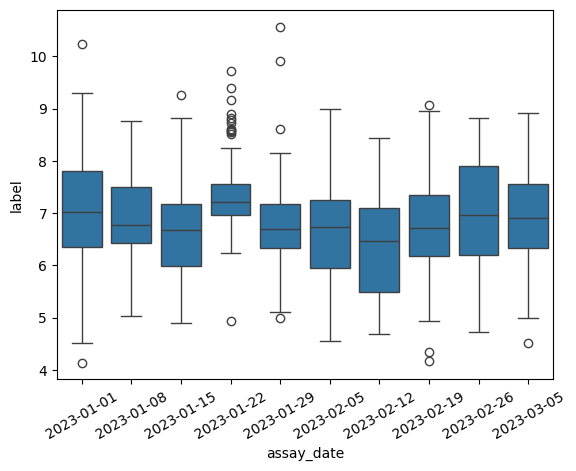

In [8]:
ax = sns.boxplot(data, x="assay_date", y="label")
ax.tick_params(axis="x", rotation=30)

## Train models

In [9]:
def get_calibration_data(
    data: pd.DataFrame, model_date: datetime.date, model_type: ModelType, confidence_transform: Transform
) -> dict[str, pd.DataFrame] | None:
    """Computes calibration data for a single model date."""
    mask = data["assay_date"].dt.date <= model_date
    if mask.sum() == len(data):
        return None
    model = Model(model_type=model_type)
    model.train(data[mask], confidence_transform=confidence_transform)
    cv_data = model.cv_data
    cv_data["model_date"] = model_date
    confidence_weights = model.confidence_weights
    confidence_weights["model_date"] = model_date
    calibration_data = model.calibrate(data[~mask])
    calibration_data["model_date"] = model_date
    return {"cv_data": cv_data, "confidence_weights": confidence_weights, "calibration_data": calibration_data}

In [10]:
# Train models and get calibration statistics.
results = defaultdict(list)
for model_date in tqdm(get_training_dates(data["assay_date"])):
    result = get_calibration_data(
        data, model_date=model_date, model_type=MODEL_TYPE, confidence_transform=Transform.LOG
    )
    if result is None:
        continue
    for key, value in result.items():
        results[key].append(value)
cv_data = pd.concat(results["cv_data"], ignore_index=True)
confidence_weights = pd.concat(results["confidence_weights"], ignore_index=True)
calibration_data = pd.concat(results["calibration_data"], ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.03s/it]


## Analyze

### Cross-validation performance

In [11]:
print(cv_data.shape)
cv_data.sample(5)

(4494, 8)


,fold,mol_index,mol_id,smiles,label,location,scale,model_date
1921,7,22,CHEMBL1201343,CCCN[C@H]1CCC2N=C(N)SC2C1,8.41,6.397492,0.847028,2023-02-05
1232,4,380,CHEMBL234476,O=S(=O)(N[C@H]1CC[C@@H](N2CCN(c3ccccc3OCC3CC3)...,6.37,6.417266,0.356927,2023-01-29
311,0,95,CHEMBL164950,CCCN(CCC)C1CCC(=C(C#N)C#N)CC1,4.82,5.265875,0.599193,2023-01-15
3118,3,796,CHEMBL477055,O=C1c2ccccc2CCCN1CCCN1CCN(c2cccc(Cl)c2Cl)CC1,6.66,5.821873,0.184121,2023-02-19
3240,5,433,CHEMBL262724,O=C(NCCCCN1CCN(c2cccc(Cl)c2Cl)CC1)c1cnc2ccccc2n1,7.53,7.183531,0.415498,2023-02-19


In [12]:
rows = []
for (model_date, fold), df in cv_data.groupby(["model_date", "fold"]):
    rows.append(
        {
            "model_date": model_date,
            "fold": fold,
            "r2_score": r2_score(df["label"], df["location"]),
            "mae": mean_absolute_error(df["label"], df["location"]),
        }
    )
cv_metrics = pd.DataFrame(rows)
print(cv_metrics.shape)
cv_metrics.head()

(90, 4)


,model_date,fold,r2_score,mae
0,2023-01-01,0,0.274293,0.762519
1,2023-01-01,1,0.845410,0.466787
2,2023-01-01,2,0.546782,0.841734
3,2023-01-01,3,0.049599,0.552885
4,2023-01-01,4,-0.165674,0.762946


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


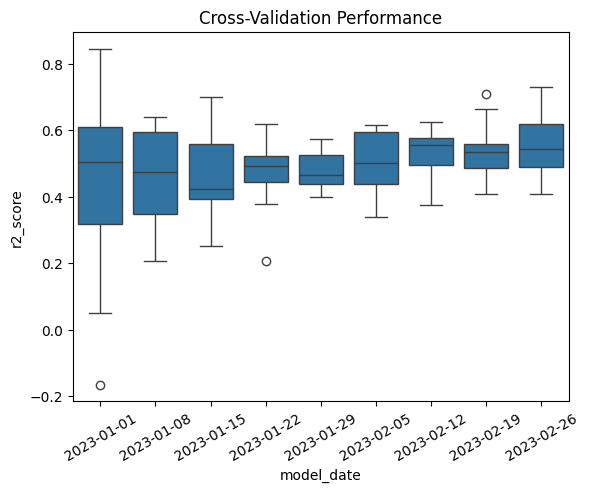

In [13]:
ax = sns.boxplot(cv_metrics, x="model_date", y="r2_score")
ax.set_title("Cross-Validation Performance")
ax.tick_params(axis="x", rotation=30)

### Confidence model parameters

In [14]:
confidence_weights.sample(5)

,threshold,u_location,u_scale,s_location,s_scale,w_location,w_scale,intercept,model_date
5,10.0,6.997744,0.509749,0.729963,0.193691,-0.345292,-0.931124,2.322012,2023-01-08
20,10.0,6.839254,0.411184,0.757155,0.218812,-0.369731,-1.183053,2.681667,2023-02-12
11,10.0,6.988398,0.422752,0.740676,0.207117,-0.305947,-0.966475,2.462649,2023-01-22
16,3.0,6.909806,0.423862,0.740976,0.193558,-0.218533,-0.440248,0.493756,2023-02-05
8,10.0,6.863339,0.490256,0.726337,0.187271,-0.559140,-1.346127,2.401387,2023-01-15


Text(0, 0.5, '')

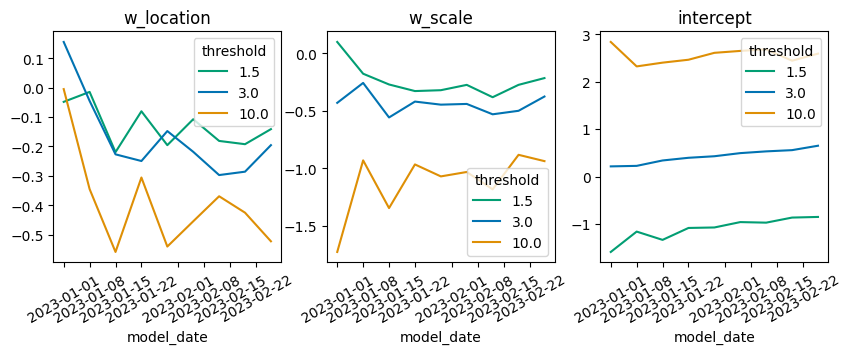

In [15]:
fig, axes = plt.subplots(figsize=(10, 3), ncols=3)

sns.lineplot(confidence_weights, x="model_date", y="w_location", hue="threshold", palette=COLORS[:3], ax=axes[0])
axes[0].set_title("w_location")
axes[0].tick_params(axis="x", rotation=30)
axes[0].set_ylabel(None)

sns.lineplot(confidence_weights, x="model_date", y="w_scale", hue="threshold", palette=COLORS[:3], ax=axes[1])
axes[1].set_title("w_scale")
axes[1].tick_params(axis="x", rotation=30)
axes[1].set_ylabel(None)

sns.lineplot(confidence_weights, x="model_date", y="intercept", hue="threshold", palette=COLORS[:3], ax=axes[2])
axes[2].set_title("intercept")
axes[2].tick_params(axis="x", rotation=30)
axes[2].set_ylabel(None)

### Confidence level calibration

In [16]:
# Reduce model predictions to the "global" set with a single prediction for each compound.
# Use a calibration gap of zero weeks since the assay dates are arbitrary for this dataset.
calibration_data["model_date"] = pd.to_datetime(calibration_data["model_date"])
global_data = get_global_calibration_data(calibration_data, delta=datetime.timedelta(weeks=0))
print(global_data.shape)
global_data.sample(5)

(896, 16)


,smiles,mol_id,label,assay_date,normalized_smiles,location,scale,p(within 1.5x),p(within 3x),p(within 10x),confidence_level,transform,confidence_level_best_case,confidence_level_calibration,model_date,max_prediction_date
940,CN1CCN(C2=Nc3cc(Cl)ccc3N(NC(=O)c3c(F)cccc3C(F)...,CHEMBL213492,6.42,2023-01-15,CN1CCN(C2=Nc3cc(Cl)ccc3N(NC(=O)c3c(F)cccc3C(F)...,6.445778,0.866278,0.185991,0.446529,0.704574,D,LOG,A,UNDERCONFIDENT,2023-01-08,2023-01-15
3916,OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2Cc1ccc(F)cc1,CHEMBL456430,5.98,2023-02-19,OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2Cc1ccc(F)cc1,7.447478,0.526487,0.210952,0.503014,0.853366,C,LOG,D,OVERCONFIDENT,2023-02-12,2023-02-19
903,O=C(CCCN1CCN(c2ncccn2)CC1)c1nc2ccccc2s1,CHEMBL2037519,5.82,2023-01-15,O=C(CCCN1CCN(c2ncccn2)CC1)c1nc2ccccc2s1,6.134599,0.609762,0.225327,0.536370,0.904609,C,LOG,B,UNDERCONFIDENT,2023-01-08,2023-01-15
3910,CCCN(CCc1ccc(NC(=O)CCC(=O)NCCCCCC(=O)NCc2ccc(C...,CHEMBL4541515,8.66,2023-02-19,CCCN(CCc1ccc(NC(=O)CCC(=O)NCCCCCC(=O)NCc2ccc(C...,6.973013,0.804451,0.155706,0.383370,0.620121,D,LOG,D,CORRECT,2023-02-12,2023-02-19
4449,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,CHEMBL715,7.00,2023-03-05,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,7.417446,0.721548,0.215007,0.478176,0.674335,D,LOG,B,UNDERCONFIDENT,2023-02-26,2023-03-05


In [17]:
print("Time-split validation")
print("R2", r2_score(global_data["label"], global_data["location"]))
print("MAE", mean_absolute_error(global_data["label"], global_data["location"]))

Time-split validation
R2 0.210921079852892
MAE 0.6437075709196798


In [18]:
global_data["confidence_level"].value_counts()

confidence_level
D    471
C    405
B     20
Name: count, dtype: int64

In [19]:
global_data["confidence_level_calibration"].value_counts()

confidence_level_calibration
UNDERCONFIDENT    576
CORRECT           246
OVERCONFIDENT      74
Name: count, dtype: int64

In [20]:
accurate = global_data["confidence_level_calibration"].isin([Calibration.UNDERCONFIDENT.name, Calibration.CORRECT.name])
print("Accuracy:", f"{accurate.sum() / len(global_data):.2%}")

Accuracy: 91.74%


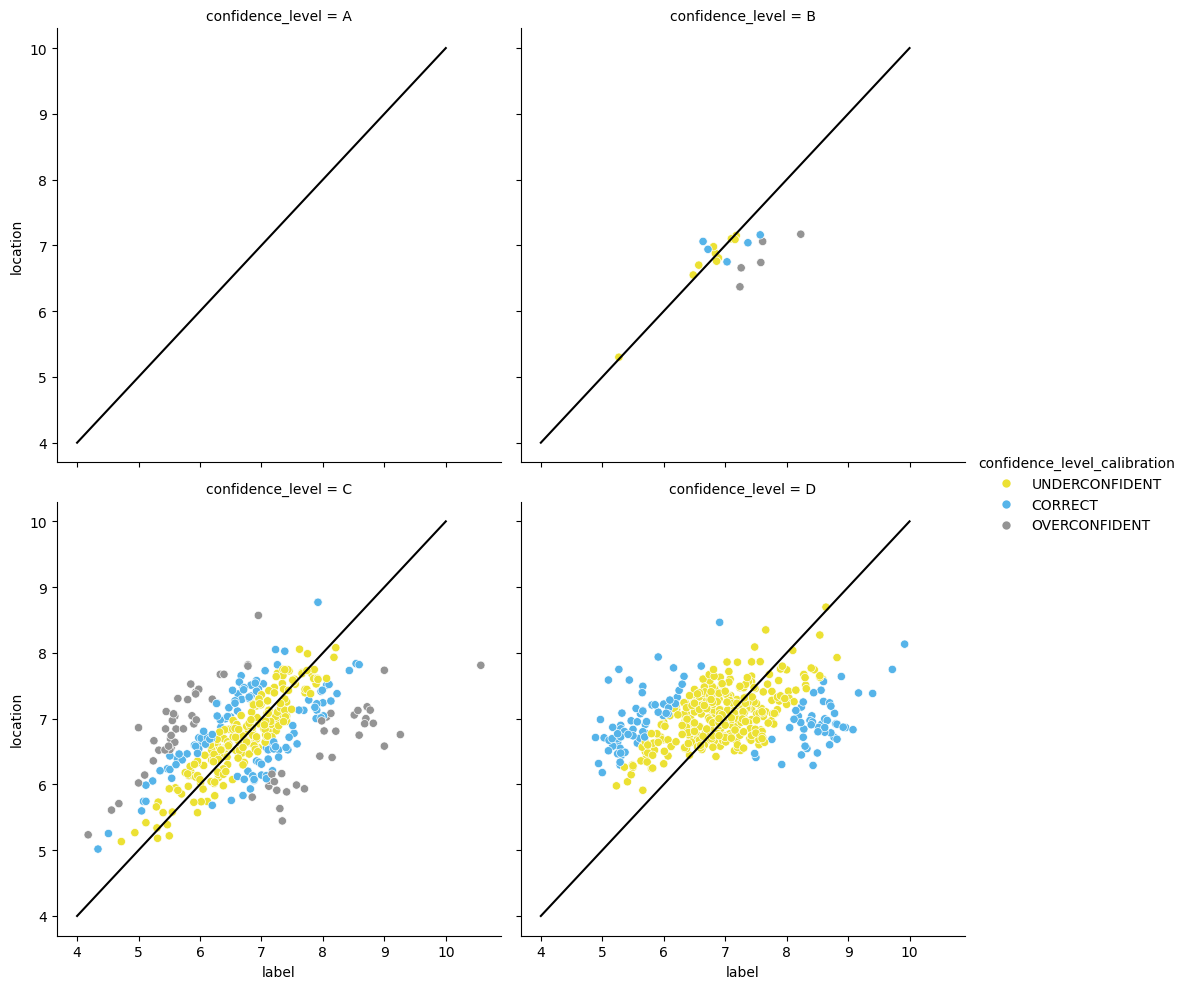

In [21]:
fig = sns.relplot(
    global_data,
    x="label",
    y="location",
    col="confidence_level",
    col_order=CONFIDENCE_LEVELS,
    col_wrap=2,
    hue="confidence_level_calibration",
    hue_order=CALIBRATION_LEVELS,
    palette=CALIBRATION_COLORS,
)
for ax in fig.axes:
    _ = ax.plot([4, 10], [4, 10], color="black")

## Baseline

In [22]:
baseline_calibration_data = get_baseline_calibration_data(calibration_data, transform=Transform.LOG)
baseline_global_data = get_global_calibration_data(baseline_calibration_data, delta=datetime.timedelta(weeks=0))
print(baseline_global_data.shape)
baseline_global_data.sample(5)

(896, 14)


,mol_id,label,assay_date,location,scale,transform,model_date,p(within 1.5x),p(within 3x),p(within 10x),confidence_level,confidence_level_best_case,confidence_level_calibration,max_prediction_date
3530,CHEMBL4060194,5.36,2023-02-12,6.803799,0.850914,LOG,2023-02-05,0.163946,0.425009,0.760088,D,D,CORRECT,2023-02-12
4444,CHEMBL69451,7.61,2023-03-05,7.130127,0.365175,LOG,2023-02-26,0.370344,0.808636,0.993826,B,C,OVERCONFIDENT,2023-03-05
3480,CHEMBL382773,7.20,2023-02-12,6.540107,0.401180,LOG,2023-02-05,0.339290,0.765676,0.987320,C,C,CORRECT,2023-02-12
3926,CHEMBL460644,5.93,2023-02-19,6.112553,0.514430,LOG,2023-02-12,0.267877,0.646320,0.948092,C,B,UNDERCONFIDENT,2023-02-19
2437,CHEMBL281048,6.58,2023-01-29,7.395155,0.703720,LOG,2023-01-22,0.197590,0.502227,0.844689,C,C,CORRECT,2023-01-29


In [23]:
baseline_global_data["confidence_level"].value_counts()

confidence_level
C    583
D    221
B     54
A     38
Name: count, dtype: int64

In [24]:
baseline_global_data["confidence_level_calibration"].value_counts()

confidence_level_calibration
UNDERCONFIDENT    433
CORRECT           302
OVERCONFIDENT     161
Name: count, dtype: int64

In [25]:
accurate = baseline_global_data["confidence_level_calibration"].isin(
    [Calibration.UNDERCONFIDENT.name, Calibration.CORRECT.name]
)
print("Baseline accuracy:", f"{accurate.sum() / len(global_data):.2%}")

Baseline accuracy: 82.03%


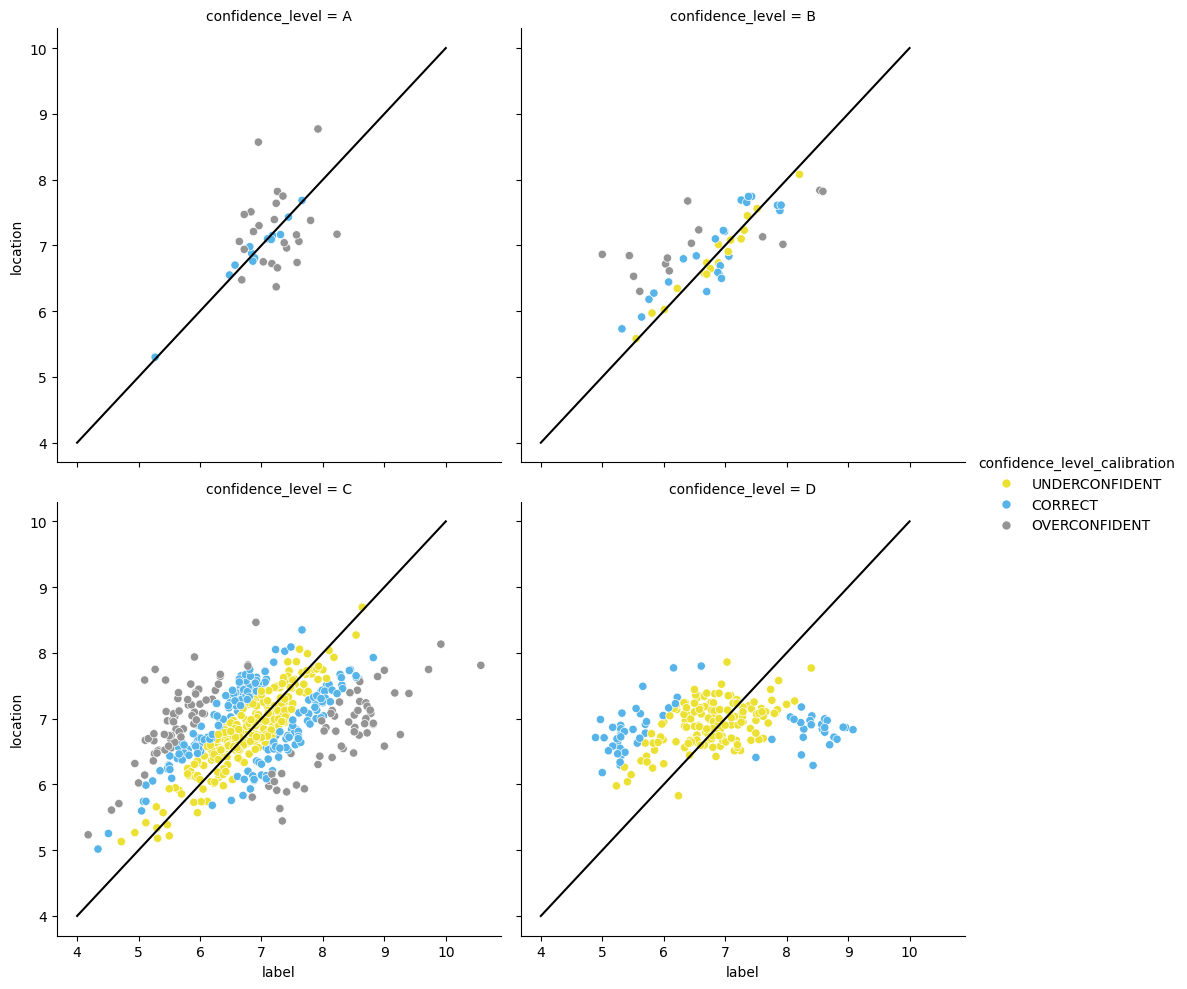

In [26]:
fig = sns.relplot(
    baseline_global_data,
    x="label",
    y="location",
    col="confidence_level",
    col_order=CONFIDENCE_LEVELS,
    col_wrap=2,
    hue="confidence_level_calibration",
    hue_order=CALIBRATION_LEVELS,
    palette=CALIBRATION_COLORS,
)
for ax in fig.axes:
    _ = ax.plot([4, 10], [4, 10], color="black")